In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

In [2]:
gpu_ids = []
device_names = []
if torch.cuda.is_available():
    for gpu_id in range(torch.cuda.device_count()):
        gpu_ids += [gpu_id]
        device_names += [torch.cuda.get_device_name(gpu_id)]
print(gpu_ids)
print(device_names)

if len(gpu_ids) > 1:
    device = 'cuda:' + str(gpu_ids[0])  # 여기서 gpu 번호 고르기
else:
    device = "cuda" if torch.cuda.is_available() else "cpu"

print(device)

[0]
['NVIDIA GeForce RTX 3080']
cuda


In [3]:
points, labels = make_moons(n_samples=2000, shuffle=False ,noise=0.1)

In [4]:
points_l = np.array((points[10], points[500], points[900], points[1300], points[1500], points[1800]))
labels_l = np.array((labels[10], labels[500], labels[900], labels[1300], labels[1500], labels[1800]))

In [5]:
# print(points[0], labels[0], points[500], labels[500], points[999], labels[999])
# print(points[1300], labels[1300], points[1500], labels[1500], points[1800], labels[1800])

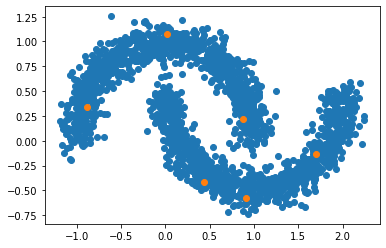

In [6]:
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])

In [7]:
class TMClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=8),
            nn.Sigmoid(),
            nn.Linear(in_features=8, out_features=8),
            nn.Sigmoid(),
            nn.Linear(in_features=8, out_features=2),
            nn.Sigmoid()
        )

        self.init_weight()

    def init_weight(self):
        for layer in self.layers:
            if(isinstance(layer, nn.Linear)):
                nn.init.uniform_(layer.weight, -0.1, 0.1)

    def forward(self, x):
        return self.layers(x)

In [8]:
supervised = TMClassifier().to(device=device)
pseudoLabel = TMClassifier().to(device=device)
metaPseudoLabel = TMClassifier().to(device=device)
lr = 0.1
opt_s = torch.optim.SGD(supervised.parameters(), lr=lr)
opt_pl = torch.optim.SGD(pseudoLabel.parameters(), lr=lr)
opt_mpl = torch.optim.SGD(metaPseudoLabel.parameters(), lr=lr)

In [9]:
creterion = nn.CrossEntropyLoss()

In [10]:
class MyDataset(Dataset):
    def __init__(self, x_data, y_data, transform=None):
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform
        self.len = len(y_data)
    
    def __getitem__(self, index):
        sample = self.x_data[index], self.y_data[index]
        
        if self.transform:
            sample = self.transform(sample)   #self.transform이 None이 아니라면 전처리
        return sample 
    
    def __len__(self):
        return self.len

In [11]:
labeledData = MyDataset(points_l, labels_l)
unlabeledData = MyDataset(points, labels)

labeledLoader = DataLoader(labeledData, batch_size=6, shuffle=True)
unlabeledLoader = DataLoader(unlabeledData, batch_size=1024, shuffle=True)

In [12]:
epoch = 0
max_epoch = 3e4

In [13]:
while(epoch < max_epoch):
    for point, label in labeledLoader:
        opt_s.zero_grad()

        output = supervised(point.float().to(device))

        loss = creterion(output.cpu(), label)

        loss.backward()
        opt_s.step()

    if(epoch%1e3 == 0):
        _, preds = torch.max(output, 1)
        acc = torch.sum(preds.cpu() == label)

        print(f'Epoch: {epoch} \tLoss: {loss.item():.4f} \tAcc: {acc.item()}')
    
    epoch += 1

Epoch: 0 	Loss: 0.6932 	Acc: 3
Epoch: 1000 	Loss: 0.6931 	Acc: 3
Epoch: 2000 	Loss: 0.6931 	Acc: 3
Epoch: 3000 	Loss: 0.6930 	Acc: 3
Epoch: 4000 	Loss: 0.6930 	Acc: 4
Epoch: 5000 	Loss: 0.6928 	Acc: 5
Epoch: 6000 	Loss: 0.6922 	Acc: 5
Epoch: 7000 	Loss: 0.6897 	Acc: 5
Epoch: 8000 	Loss: 0.6657 	Acc: 5
Epoch: 9000 	Loss: 0.4749 	Acc: 5
Epoch: 10000 	Loss: 0.3581 	Acc: 6
Epoch: 11000 	Loss: 0.3310 	Acc: 6
Epoch: 12000 	Loss: 0.3233 	Acc: 6
Epoch: 13000 	Loss: 0.3200 	Acc: 6
Epoch: 14000 	Loss: 0.3183 	Acc: 6
Epoch: 15000 	Loss: 0.3172 	Acc: 6
Epoch: 16000 	Loss: 0.3165 	Acc: 6
Epoch: 17000 	Loss: 0.3160 	Acc: 6
Epoch: 18000 	Loss: 0.3156 	Acc: 6
Epoch: 19000 	Loss: 0.3153 	Acc: 6
Epoch: 20000 	Loss: 0.3151 	Acc: 6
Epoch: 21000 	Loss: 0.3149 	Acc: 6
Epoch: 22000 	Loss: 0.3147 	Acc: 6
Epoch: 23000 	Loss: 0.3146 	Acc: 6
Epoch: 24000 	Loss: 0.3145 	Acc: 6
Epoch: 25000 	Loss: 0.3144 	Acc: 6
Epoch: 26000 	Loss: 0.3143 	Acc: 6
Epoch: 27000 	Loss: 0.3143 	Acc: 6
Epoch: 28000 	Loss: 0.3142 	Acc: 

In [14]:
epoch = 0

while(epoch < max_epoch):
    for point, label in unlabeledLoader:
        opt_pl.zero_grad()

        pseudo_label = supervised(point.float().to(device))
        output = pseudoLabel(point.float().to(device))

        loss = creterion(output, pseudo_label)

        loss.backward()
        opt_pl.step()

    if(epoch%1e3 == 0):
        _, preds = torch.max(output, 1)
        acc = torch.sum(preds == label.to(device))

        print(f'Epoch: {epoch} \tLoss: {loss.item():.4f} \tAcc: {acc.item()}')
    
    epoch += 1

Epoch: 0 	Loss: 0.7032 	Acc: 494
Epoch: 1000 	Loss: 0.6505 	Acc: 490
Epoch: 2000 	Loss: 0.6474 	Acc: 485
Epoch: 3000 	Loss: 0.6433 	Acc: 480
Epoch: 4000 	Loss: 0.6266 	Acc: 487
Epoch: 5000 	Loss: 0.4707 	Acc: 821
Epoch: 6000 	Loss: 0.3683 	Acc: 807
Epoch: 7000 	Loss: 0.3534 	Acc: 818
Epoch: 8000 	Loss: 0.3457 	Acc: 826
Epoch: 9000 	Loss: 0.3411 	Acc: 820
Epoch: 10000 	Loss: 0.3410 	Acc: 810
Epoch: 11000 	Loss: 0.3407 	Acc: 817
Epoch: 12000 	Loss: 0.3402 	Acc: 824
Epoch: 13000 	Loss: 0.3390 	Acc: 810
Epoch: 14000 	Loss: 0.3364 	Acc: 808
Epoch: 15000 	Loss: 0.3335 	Acc: 827
Epoch: 16000 	Loss: 0.3359 	Acc: 826
Epoch: 17000 	Loss: 0.3352 	Acc: 816
Epoch: 18000 	Loss: 0.3374 	Acc: 822
Epoch: 19000 	Loss: 0.3358 	Acc: 827
Epoch: 20000 	Loss: 0.3366 	Acc: 823
Epoch: 21000 	Loss: 0.3360 	Acc: 807
Epoch: 22000 	Loss: 0.3380 	Acc: 813
Epoch: 23000 	Loss: 0.3383 	Acc: 804
Epoch: 24000 	Loss: 0.3359 	Acc: 816
Epoch: 25000 	Loss: 0.3328 	Acc: 803
Epoch: 26000 	Loss: 0.3344 	Acc: 829
Epoch: 27000 	

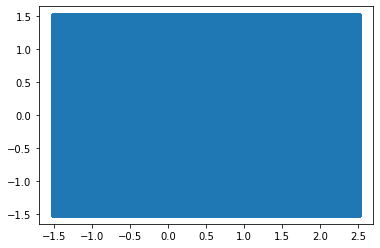

In [15]:
x = np.linspace(-1.5, 2.5, num=1000)
y = np.linspace(-1.5, 1.5, num=1000)

X,Y = np.meshgrid(x,y)

plt.scatter(X, Y)

In [16]:
arr = np.stack((X.flatten(),Y.flatten()),axis=1)

In [17]:
renderData = MyDataset(arr, np.zeros_like(arr))

renderLoader = DataLoader(renderData, batch_size=1024, shuffle=False, drop_last=False)

In [18]:
s_preds = np.array([])
pl_preds = np.array([])

for point, _ in renderLoader:
    # print(point)
    _, s_pred = torch.max(supervised(point.float().to(device)), 1)
    _, pl_pred = torch.max(pseudoLabel(point.float().to(device)), 1)
    # break

    s_preds = np.concatenate((s_preds,s_pred.cpu().numpy()))
    pl_preds = np.concatenate((pl_preds,pl_pred.cpu().numpy()))
    


In [19]:
print(arr.shape, s_preds.shape, pl_preds.shape)

(1000000, 2) (1000000,) (1000000,)


In [20]:
s_pred_points_0 = []
s_pred_points_1 = []
pl_pred_points_0 = []
pl_pred_points_1 = []

for i in range(arr.shape[0]):
    if(s_preds[i] == 0):
        s_pred_points_0.append(arr[i])
    else:
        s_pred_points_1.append(arr[i])
    if(pl_preds[i] == 0):
        pl_pred_points_0.append(arr[i])
    else:
        pl_pred_points_1.append(arr[i])

print(len(s_pred_points_0),len(s_pred_points_1))
print(len(pl_pred_points_0),len(pl_pred_points_1))

536508 463492
536429 463571


In [21]:
np.array(s_pred_points_0).shape

(536508, 2)

[None, None]

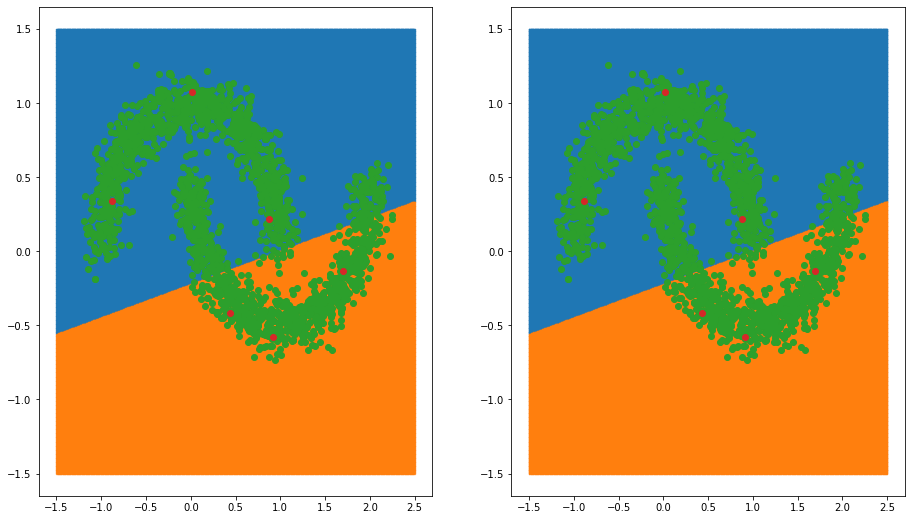

In [31]:
gridshape = (1, 3)
marker_size = 0.1

loc = (0,0)
ax = plt.subplot2grid(gridshape, loc)
ax.figure

plt.scatter(np.array(s_pred_points_0)[:,0], np.array(s_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(s_pred_points_1)[:,0], np.array(s_pred_points_1)[:,1], s=marker_size)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])


loc = (0,1)
ax = plt.subplot2grid(gridshape, loc)

plt.scatter(np.array(pl_pred_points_0)[:,0], np.array(pl_pred_points_0)[:,1], s=marker_size)
plt.scatter(np.array(pl_pred_points_1)[:,0], np.array(pl_pred_points_1)[:,1], s=marker_size)
plt.scatter(points[:,0],points[:,1])
plt.scatter(points_l[:,0],points_l[:,1])

ax.figure.set(figwidth=24, figheight=9)